In [1]:
import pandas as pd
import numpy as np
import os
import json
import re
from pandas.io.json import json_normalize
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import spacy
from nltk.corpus import wordnet as wn
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import seaborn as sns

In [2]:
with open('train_data-1573118738755.json','r') as f:
    Tweet=json.load(f)

In [3]:
Tweet=pd.concat([pd.DataFrame(Tweet),pd.DataFrame(list(Tweet['records']))], axis=1).drop('records', 1)

In [4]:
Tweet.head(5)

,stocktwit_tweet,sentiment_score,timestamp,ticker
0,$AMD going up but hesitating however chart is ...,3,2018-09-19 18:38:28+00:00,$AMD
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09 03:51:06+00:00,$CAT
2,$AVGO WTF?,2,2018-07-12 13:35:32+00:00,$AVGO
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,2018-07-19 03:32:50+00:00,$PH
4,$FB if it bounces tommorrow do the right thing...,3,2018-08-23 19:07:54+00:00,$FB


In [5]:
Tweet.sentiment_score.value_counts()

2    464402
3    208031
4    153905
1    120771
0     92022
Name: sentiment_score, dtype: int64

In [6]:
Tweet.shape

(1039131, 4)

In [7]:
Tweet['tweets']=Tweet['stocktwit_tweet']

In [8]:
Tweet.head(5)

,stocktwit_tweet,sentiment_score,timestamp,ticker,tweets
0,$AMD going up but hesitating however chart is ...,3,2018-09-19 18:38:28+00:00,$AMD,$AMD going up but hesitating however chart is ...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09 03:51:06+00:00,$CAT,@inforlong @MariaGascon Despite\nChina trade w...
2,$AVGO WTF?,2,2018-07-12 13:35:32+00:00,$AVGO,$AVGO WTF?
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,2018-07-19 03:32:50+00:00,$PH,$PH\n New Insider Filing On: \n MULLER KLAUS P...
4,$FB if it bounces tommorrow do the right thing...,3,2018-08-23 19:07:54+00:00,$FB,$FB if it bounces tommorrow do the right thing...


### Removing  symbol in ticker

In [9]:
Tweet['ticker']=[re.sub("\$"," ",i) for i in Tweet['ticker']]

### Day month Year Creating

In [10]:
import datetime

In [11]:
Tweet['timestamp']=Tweet['timestamp'].astype('datetime64[ns]')

In [12]:
Tweet['Month'] = Tweet['timestamp'].dt.month_name(locale = 'English')

In [13]:
Tweet['Day']=Tweet['timestamp'].dt.day

In [14]:
Tweet['weekday']=Tweet['timestamp'].dt.weekday_name

In [15]:
weeknumber=[]
for i in range(Tweet.shape[0]):
    weeknumber.append(Tweet['timestamp'][i].isocalendar()[1])
Tweet['WeekNumber']=weeknumber
Tweet.head(3)

,stocktwit_tweet,sentiment_score,timestamp,ticker,tweets,Month,Day,weekday,WeekNumber
0,$AMD going up but hesitating however chart is ...,3,2018-09-19 18:38:28,AMD,$AMD going up but hesitating however chart is ...,September,19,Wednesday,38
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09 03:51:06,CAT,@inforlong @MariaGascon Despite\nChina trade w...,October,9,Tuesday,41
2,$AVGO WTF?,2,2018-07-12 13:35:32,AVGO,$AVGO WTF?,July,12,Thursday,28


In [16]:
type(Tweet)

pandas.core.frame.DataFrame

In [17]:
Train=Tweet[['ticker', 'WeekNumber','sentiment_score','Month']]

In [18]:
Train.head(3)

,ticker,WeekNumber,sentiment_score,Month
0,AMD,38,3,September
1,CAT,41,3,October
2,AVGO,28,2,July


In [19]:
Train.shape

(1039131, 4)

In [20]:
Train.to_csv('Trained.csv')

In [21]:
Tweet.drop(['timestamp'], axis=1, inplace=True)

In [22]:
Tweet.head()

,stocktwit_tweet,sentiment_score,ticker,tweets,Month,Day,weekday,WeekNumber
0,$AMD going up but hesitating however chart is ...,3,AMD,$AMD going up but hesitating however chart is ...,September,19,Wednesday,38
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,@inforlong @MariaGascon Despite\nChina trade w...,October,9,Tuesday,41
2,$AVGO WTF?,2,AVGO,$AVGO WTF?,July,12,Thursday,28
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,$PH\n New Insider Filing On: \n MULLER KLAUS P...,July,19,Thursday,29
4,$FB if it bounces tommorrow do the right thing...,3,FB,$FB if it bounces tommorrow do the right thing...,August,23,Thursday,34


### expand contraction words

In [23]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [24]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [25]:
Tweet['tweets']=Tweet['tweets'].apply(expand_contractions)

### Removing non letters and puntuations

In [26]:
Tweet['tweets']=[re.sub("\n"," ",i) for i in Tweet['tweets']]

In [27]:
Tweet['tweets']=[re.sub(":"," ",i) for i in Tweet['tweets']]

In [28]:
Tweet['tweets']=[re.sub("\$"," ",i) for i in Tweet['tweets']]

In [29]:
Tweet['tweets']=[re.sub("@"," ",i) for i in Tweet['tweets']]

In [30]:
Tweet['tweets']=[re.sub("\?"," ",i) for i in Tweet['tweets']]

In [31]:
Tweet['tweets']=[re.sub("\r"," ",i) for i in Tweet['tweets']]

In [32]:
Tweet['tweets']= Tweet['tweets'].str.replace("[^a-zA-Z#]", " ") 

In [33]:
Tweet['tweets']=[re.sub("#"," ",i) for i in Tweet['tweets']]

### Removing http

In [34]:
Tweet['tweets']= Tweet['tweets'].str.replace('http\S*|www.\S*'," ", case=False)

### Removing short words

In [35]:
Tweet['tweets']= Tweet['tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

### Removing emoji

In [36]:
import emoji

Tweet['tweets']=Tweet['tweets'].apply(lambda x: emoji.demojize(x))

### Coverting uppercase to lowercase

In [37]:
Tweet['tweets']=Tweet['tweets'].str.lower()

### Removal of short words

In [38]:
Tweet['tweets']= Tweet['tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

### tweet word count

In [39]:
Tweet['word_count'] = [len(text.split(' ')) for text in Tweet['tweets']]
pd.DataFrame(Tweet['word_count']).describe()

,word_count
count,1.039131e+06
mean,1.107809e+01
std,7.951991e+00
min,1.000000e+00
25%,5.000000e+00
50%,9.000000e+00
75%,1.500000e+01
max,2.950000e+02


In [40]:
Tweet[['stocktwit_tweet','tweets']].head(20)

,stocktwit_tweet,tweets
0,$AMD going up but hesitating however chart is ...,amd going but hesitating however chart very st...
1,@inforlong @MariaGascon Despite\nChina trade w...,inforlong mariagascon despite china trade war ...
2,$AVGO WTF?,avgo wtf
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,new insider filing muller klaus peter transact...
4,$FB if it bounces tommorrow do the right thing...,bounces tommorrow the right thing and gtfo
5,$FB as usual......RED \nevery day.,usual red every day
6,$AET UnitedHealth Group Goes Ex-Dividend Today...,aet unitedhealth group goes dividend today wal...
7,$NOC let&#39;s see when we can hit 310,noc let see when can hit
8,@InCyD3R @Ferrabi I bet you’re also the one sa...,incyd ferrabi bet you also the one saying amzn...
9,$AMD Pastor the Stooge,amd pastor the stooge


### Removing stopwords

In [41]:
import nltk

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jay.pentapati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
from nltk.corpus import stopwords
stopWord_list = stopwords.words('english')
tweets_removed = [tweet for tweet in Tweet.tweets if tweet not in stopWord_list]


In [44]:
stopWord_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [45]:
Tweet[['stocktwit_tweet','tweets']].head(20)

,stocktwit_tweet,tweets
0,$AMD going up but hesitating however chart is ...,amd going but hesitating however chart very st...
1,@inforlong @MariaGascon Despite\nChina trade w...,inforlong mariagascon despite china trade war ...
2,$AVGO WTF?,avgo wtf
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,new insider filing muller klaus peter transact...
4,$FB if it bounces tommorrow do the right thing...,bounces tommorrow the right thing and gtfo
5,$FB as usual......RED \nevery day.,usual red every day
6,$AET UnitedHealth Group Goes Ex-Dividend Today...,aet unitedhealth group goes dividend today wal...
7,$NOC let&#39;s see when we can hit 310,noc let see when can hit
8,@InCyD3R @Ferrabi I bet you’re also the one sa...,incyd ferrabi bet you also the one saying amzn...
9,$AMD Pastor the Stooge,amd pastor the stooge


### Remove accented  words

In [46]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [47]:
Tweet['tweets']=Tweet['tweets'].apply(remove_accented_chars)

In [48]:
Tweet['tweets']= [expand_contractions(re.sub('â', "'", text)) for text in Tweet['tweets']]

In [49]:
#Creating function object to convert ASCII character
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [50]:
Tweet['tweets']= [remove_accented_chars(text) for text in Tweet['tweets']]

### Tokenization and lemmatization

In [51]:
data= Tweet.reset_index().to_dict(orient='list')

In [52]:
data.keys()

dict_keys(['index', 'stocktwit_tweet', 'sentiment_score', 'ticker', 'tweets', 'Month', 'Day', 'weekday', 'WeekNumber', 'word_count'])

In [53]:
Tweet.shape

(1039131, 9)

In [54]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [55]:
import spacy

In [56]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [57]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [58]:
data = Tweet.reset_index().to_dict(orient='list')

In [59]:
def tokenize_and_stem(doc, remove_stopwords = True):
    
    if remove_stopwords:
        tokens = [word.text for word in doc if not word.is_stop]
    else:
        tokens = [word.text for word in doc]

    filtered_tokens = []
   
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_and_lemmatize(doc, remove_stopwords = True):
    
    if remove_stopwords:
        tokens = [word for word in doc if not word.is_stop]
    else:
        tokens = [word for word in doc]
        
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token.text):
            filtered_tokens.append(token)
            
    lemma = [t.lemma_ for t in filtered_tokens]
    return lemma


def tokenize_only(doc, remove_stopwords = True):
    
    if remove_stopwords:
        tokens = [word.text for word in doc if not word.is_stop]
    else:
        tokens = [word.text for word in doc]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [60]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(stopwords))
print('First ten stop words: %s' % list(stopwords)[:10])
stopwords.remove('no')
stopwords.remove('not')

Number of stop words: 326
First ten stop words: ['therefore', 'further', 'very', 'becoming', 'n‘t', '’d', 'latterly', 'same', 'per', 'but']


In [61]:
%%time
data['clean_tweet_stemmed'] = []
data['clean_tweet_lemmatized'] = []
data['tweet_stemmed'] = []
data['tweet_lemmatized'] = []

vocab_stemmed = []
allvocab_stemmed =[]

vocab_tokenized = []
allvocab_tokenized = []

vocab_lemmatized = []
allvocab_lemmatized = []


for idx,text in enumerate(data['tweets']):

    doc = nlp(text)
    
    words_stemmed = tokenize_and_stem(doc)
    vocab_stemmed.extend(words_stemmed)
    data['clean_tweet_stemmed'].append(words_stemmed)
        
    words_lemmatized = tokenize_and_lemmatize(doc)
    vocab_lemmatized.extend(words_lemmatized)
    data['clean_tweet_lemmatized'].append(words_lemmatized)
    
       
    allwords_stemmed = tokenize_and_stem(doc, False)
    allvocab_stemmed.extend(allwords_stemmed)
    data['tweet_stemmed'].append(allwords_stemmed)
    
    allwords_lemmatized = tokenize_and_lemmatize(doc, False)
    allvocab_lemmatized.extend(allwords_lemmatized)
    data['tweet_lemmatized'].append(allwords_lemmatized)
    
    allwords_tokenized = tokenize_only(doc,False)
    allvocab_tokenized.extend(allwords_tokenized)
    
    words_tokenized = tokenize_only(doc)
    vocab_tokenized.extend(words_tokenized)

Wall time: 3h 22min 3s


In [62]:
print("Data Type of tweet: ",type(data['tweets']))
print("Data Type of lemmatized tweet: ",type(data['clean_tweet_stemmed']))

print("Length of data: ",len(data['tweets']))
print("Length of data: ",len(data['clean_tweet_stemmed']))

Data Type of tweet:  <class 'list'>
Data Type of lemmatized tweet:  <class 'list'>
Length of data:  1039131
Length of data:  1039131


In [63]:
print(data['tweets'][1])
print("************************************************************")

print("\n clean_tweet_stemmed \n")
print(data['clean_tweet_stemmed'][1])

print("************************************************************")
print("\n clean_tweet_lemmatized \n")
print(data['clean_tweet_lemmatized'][1])

inforlong mariagascon despite china trade war cat held very well
************************************************************

 clean_tweet_stemmed 

['inforlong', 'mariagascon', 'despit', 'china', 'trade', 'war', 'cat', 'held']
************************************************************

 clean_tweet_lemmatized 

['inforlong', 'mariagascon', 'despite', 'china', 'trade', 'war', 'cat', 'hold']


In [64]:
all_vocab_frame = pd.DataFrame({'words': allvocab_tokenized}, index = allvocab_lemmatized)
print ('there are ' + str(all_vocab_frame.shape[0]) + ' items in all_vocab_frame')

vocab_frame = pd.DataFrame({'words': vocab_tokenized}, index = vocab_lemmatized)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 11532651 items in all_vocab_frame
there are 8615069 items in vocab_frame


In [65]:
print (vocab_frame.head(20))

                   words
amd                  amd
go                 going
hesitate      hesitating
chart              chart
stable            stable
go                 going
upward            upward
inforlong      inforlong
mariagascon  mariagascon
despite          despite
china              china
trade              trade
war                  war
cat                  cat
hold                held
avgo                avgo
wtf                  wtf
new                  new
insider          insider
filing            filing


### Plotting Most frequent words before and after stopword removal

In [66]:
values, counts = np.unique(vocab_frame, return_counts=True)
all_values, all_counts = np.unique(all_vocab_frame, return_counts=True)

In [67]:
sorted_indices = np.argsort(-counts)
print(sorted_indices)
all_sorted_indices = np.argsort(-all_counts)
print(all_sorted_indices)

[  3359  18559   3131 ...  51999  52008 116725]
[ 99164   3378  18610 ...  67469  67477 117002]


In [68]:
values = values[sorted_indices]
counts = counts[sorted_indices]

all_values = all_values[all_sorted_indices]
all_counts = all_counts[all_sorted_indices]

## Frequency plot of words in blogs with stopwords removed

In [69]:
import matplotlib.pyplot as plt

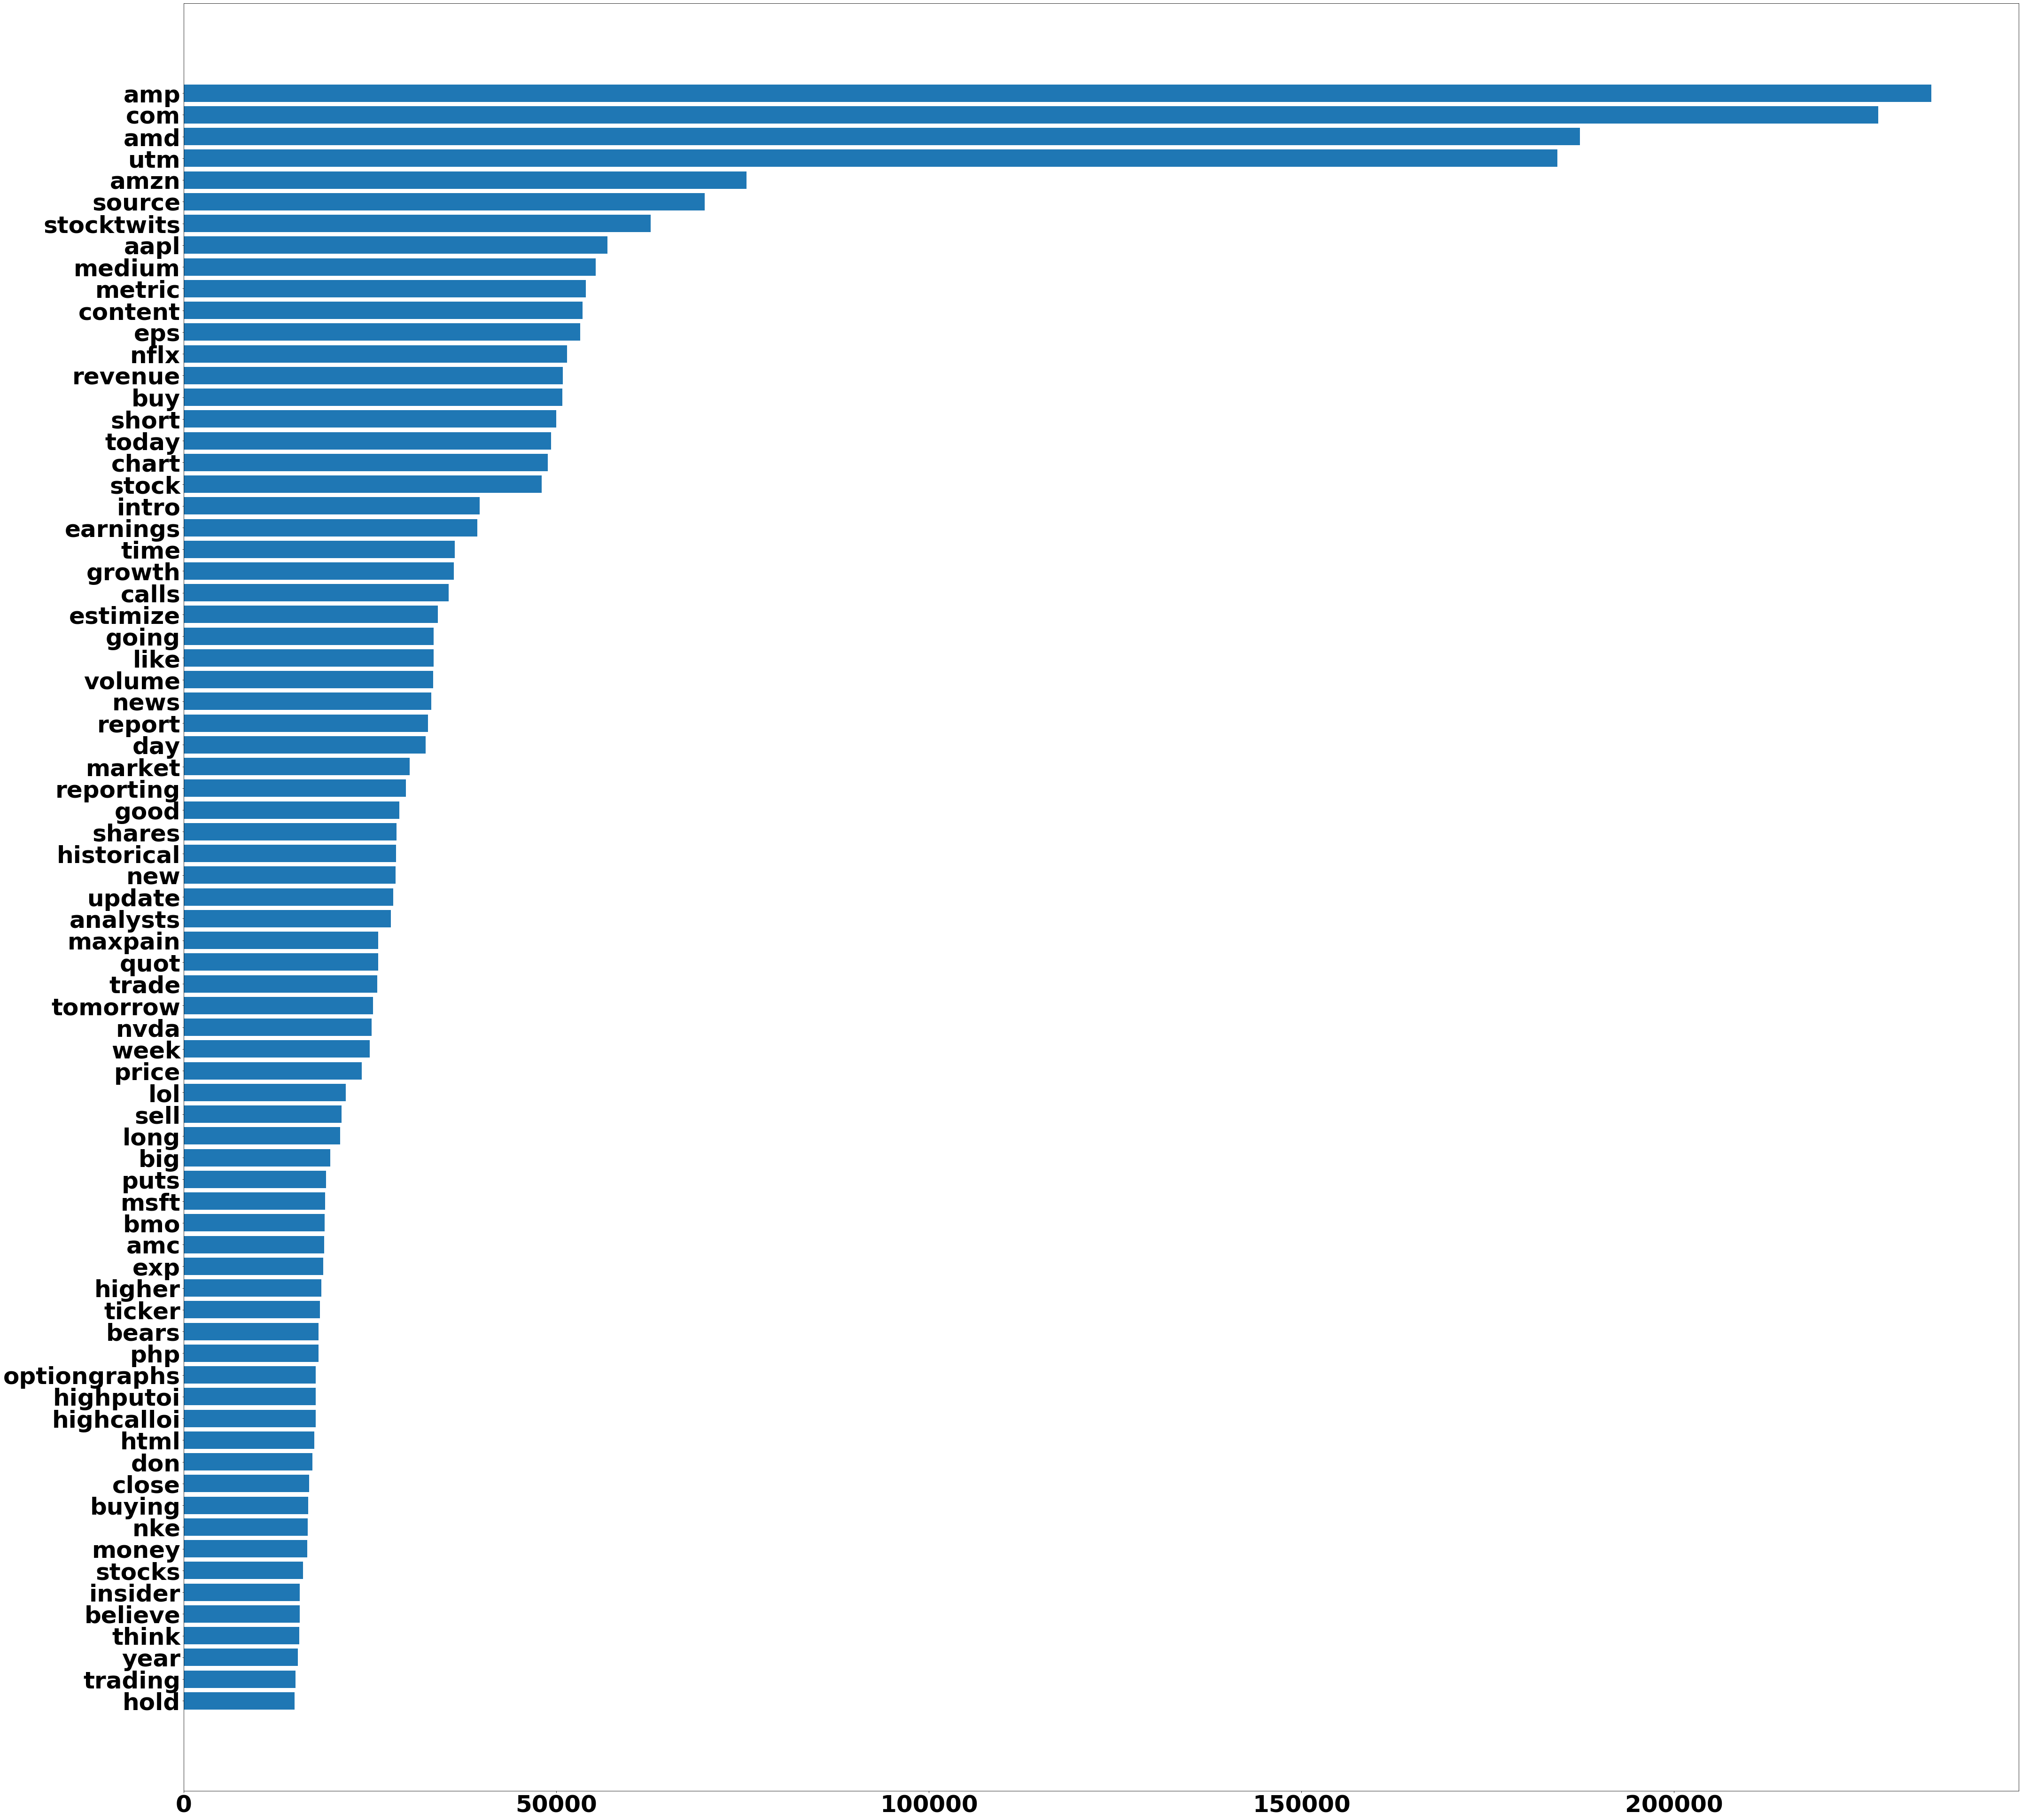

In [70]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 50}

plt.rc('font', **font)
fig = plt.figure(figsize=(70,70))
plt.barh(values[:75], counts[:75])
plt.gca().invert_yaxis()
plt.show()

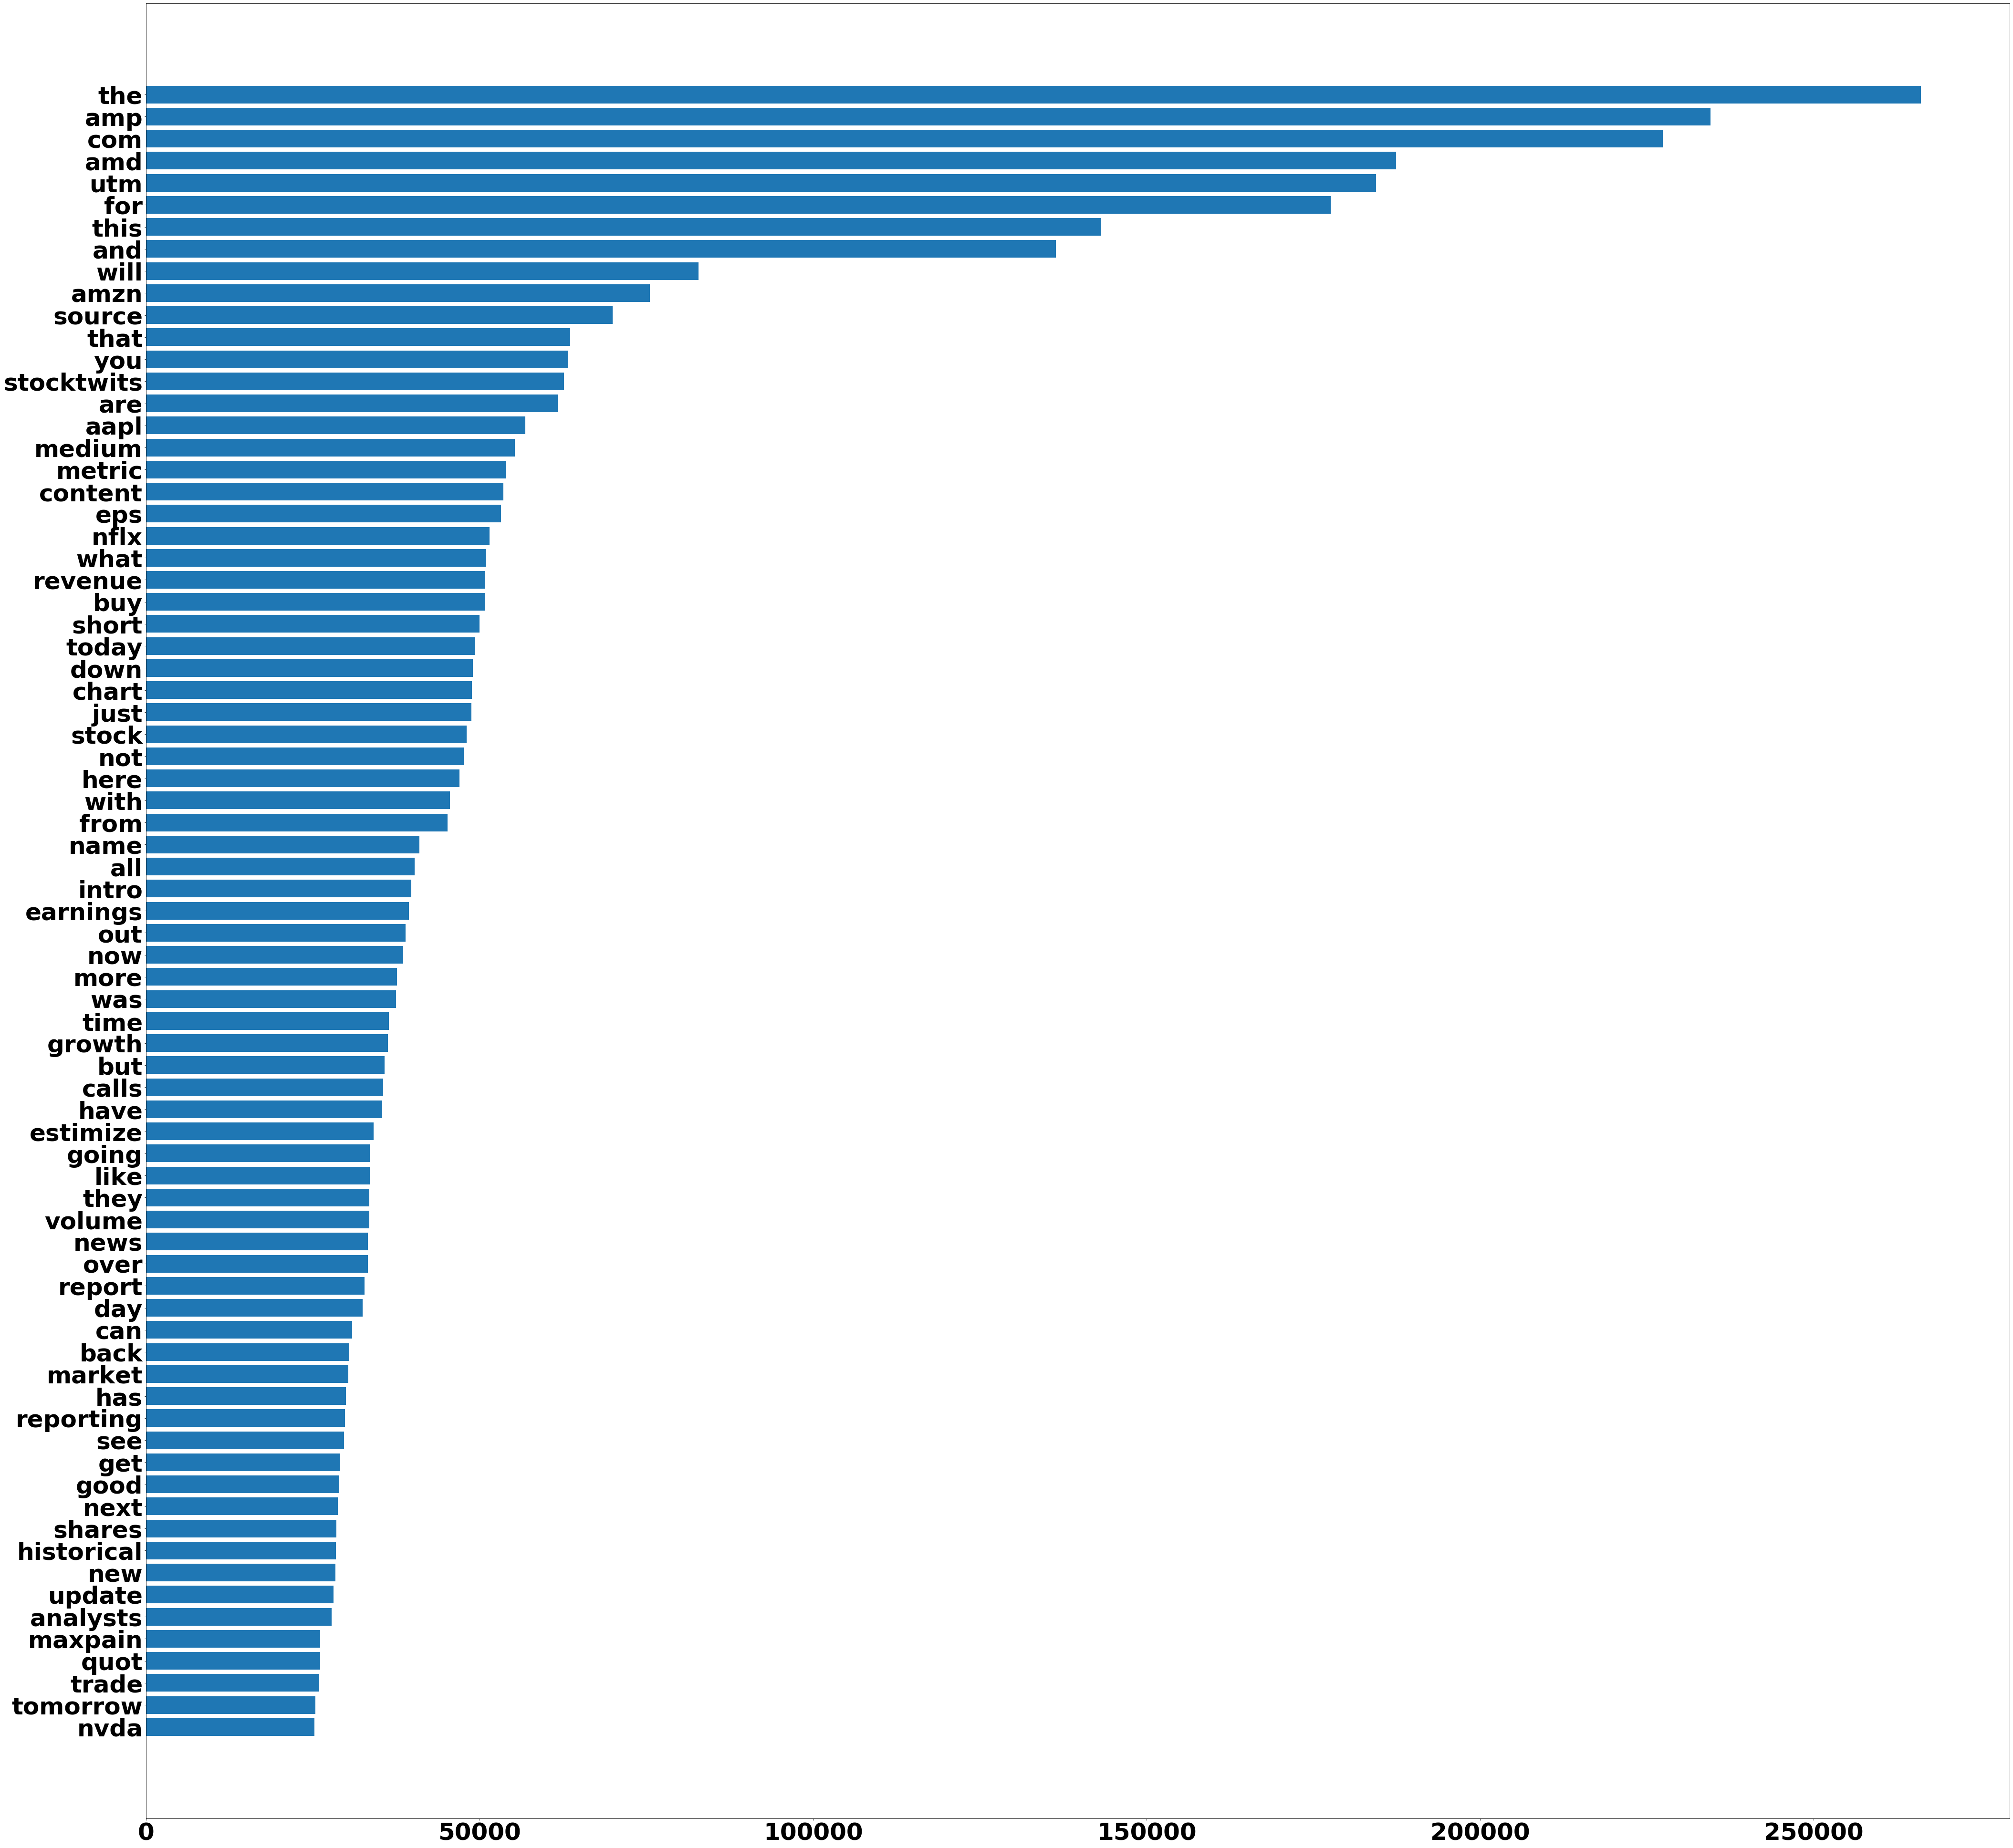

In [71]:
plt.rc('font', **font)
fig = plt.figure(figsize=(70,70))
plt.barh(all_values[:75], all_counts[:75])
plt.gca().invert_yaxis()
plt.show()

#### Observations from the Frequency Plots

1) The most occuring words present in both the graphs are quite different <br>
2) The most occuring words present in graph 1 (without stopwords) makes more sense.

In [72]:
from wordcloud import WordCloud

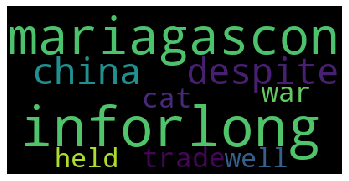

In [73]:
wordcloud = WordCloud().generate(data['tweets'][1])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

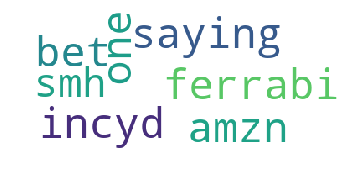

In [74]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color="white").generate(data['tweets'][8])
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [75]:
## tfidf vectorizer needs sentence and not token. Hence we need to combine all the tokens back to form a string

data['clean_tweet_stemmed'] = [' '.join(text) for text in data['clean_tweet_stemmed']]
data['clean_tweet_lemmatized'] = [' '.join(text) for text in data['clean_tweet_lemmatized']]
data['clean_tweet_lemmatized'][0]

'amd go hesitate chart stable go upward'

In [76]:
type(data)

dict

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train,X_test,y_train,y_test=train_test_split(data['clean_tweet_lemmatized'],data['sentiment_score'],test_size=0.3, random_state=100)

In [79]:
print(len (X_train))


727391


### Countvectorizer

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [81]:
countvector_train=CountVectorizer(stop_words='english', lowercase=True, strip_accents='unicode', decode_error='ignore')

In [82]:
countvector_train.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='ignore',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [83]:
countvector_train.transform(X_train)

<727391x88338 sparse matrix of type '<class 'numpy.int64'>'
	with 5176637 stored elements in Compressed Sparse Row format>

In [84]:
#X_train_tfidf is the tfidf format of X train which passes as an argument to the models
X_train_cv=countvector_train.transform(X_train)

In [85]:
X_test_cv=countvector_train.transform(X_test)

### RandomForest

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
#create the model with 100 trees
Classifier=RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=500, bootstrap=True, max_features='sqrt',
                                 min_samples_leaf=2, random_state=100)

In [88]:
Classifier.fit(X_train_cv, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=500, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [89]:
#prediction on train data
y_train_pred=Classifier.predict(X_train_cv)

In [90]:
#confusion matrix on train data
confusion_matrix(y_train,y_train_pred)

array([[ 28606,   3295,  27260,   2863,   2223],
       [  2914,  26260,  41746,   8859,   5150],
       [  3472,   1669, 303136,   9602,   7196],
       [  3130,   4467,  75961,  51103,  10576],
       [   459,    417,  32997,  16013,  58017]], dtype=int64)

In [91]:
print(classification_report(y_true=y_train,y_pred=y_train_pred))

              precision    recall  f1-score   support

           0       0.74      0.45      0.56     64247
           1       0.73      0.31      0.43     84929
           2       0.63      0.93      0.75    325075
           3       0.58      0.35      0.44    145237
           4       0.70      0.54      0.61    107903

    accuracy                           0.64    727391
   macro avg       0.67      0.52      0.56    727391
weighted avg       0.65      0.64      0.61    727391



In [92]:
from sklearn.metrics import f1_score

In [93]:
print(f1_score(y_train,y_train_pred, average="macro"))

0.5574040487731424


## prediction on test data

In [95]:
y_test_pred=Classifier.predict(X_test_cv)

In [96]:
#confusion matrix on test data
confusion_matrix(y_test,y_test_pred)

array([[ 11603,   1467,  12407,   1338,    960],
       [  1251,  10244,  18295,   3839,   2213],
       [  1673,    859, 128742,   4613,   3440],
       [  1435,   1995,  34083,  20418,   4863],
       [   227,    199,  14731,   7218,  23627]], dtype=int64)

In [97]:
print(classification_report(y_true=y_test,y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.72      0.42      0.53     27775
           1       0.69      0.29      0.40     35842
           2       0.62      0.92      0.74    139327
           3       0.55      0.33      0.41     62794
           4       0.67      0.51      0.58     46002

    accuracy                           0.62    311740
   macro avg       0.65      0.49      0.53    311740
weighted avg       0.63      0.62      0.59    311740



In [98]:
print(f1_score(y_test,y_test_pred, average="macro"))

0.5327130263425722


## Predicting alpha using sentiment_score

In [168]:
train_data=pd.read_csv("train_factors-1573207730757.csv")

In [169]:
train_data.shape

(27006, 11)

In [170]:
train_data.head(3)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1


In [171]:
train_data['date']=pd.to_datetime(train_data['date'].astype(str),format="%d/%m/%y")

In [172]:
train_data['Month']=train_data['date'].dt.month_name(locale='English')
train_data['Day']=train_data['date'].dt.day
train_data['weekday']=train_data['date'].dt.weekday_name

In [173]:
weeknumber=[]
for i in range(train_data.shape[0]):
    weeknumber.append(train_data['date'][i].isocalendar()[1])
train_data['WeekNumber']=weeknumber
train_data.head(3)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Month,Day,weekday,WeekNumber
0,1,2018-08-21,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,August,21,Tuesday,34
1,2,2018-10-11,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,October,11,Thursday,41
2,3,2018-08-21,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,August,21,Tuesday,34


In [174]:
import re

In [175]:
train_data['ticker']=[re.sub("\$"," ",i) for i in train_data['ticker']]

In [176]:
train_data['ticker']=train_data['ticker'].astype('category')

### merging with sentiment_score

In [177]:
train=pd.read_csv("Traine.csv")

In [178]:
train.head(3)

,ticker,WeekNumber,sentiment_score,Month
0,AMD,38,3,September
1,CAT,41,3,October
2,AVGO,28,2,July


In [179]:
train['ticker']=train['ticker'].astype('category')

In [180]:
train['Month']=train['Month'].astype('category')

In [181]:
train_ne= pd.DataFrame(train.groupby(['ticker','WeekNumber'])['sentiment_score'].mean())

In [182]:
train_ne.reset_index()

,ticker,WeekNumber,sentiment_score
0,AAPL,26,NaN
1,AAPL,27,NaN
2,AAPL,28,NaN
3,AAPL,29,NaN
4,AAPL,30,NaN
...,...,...,...
41510,MU,40,NaN
41511,MU,41,NaN
41512,MU,42,NaN
41513,MU,43,NaN


In [183]:
data=pd.merge(train_data,train_ne, on=['ticker','WeekNumber'],how='left')

In [184]:
data.shape

(27006, 16)

In [185]:
data.isnull().sum()

Id                   0
date                 0
ticker               0
SF1                  0
SF2                  0
SF3                  0
SF4                  0
SF5                  0
SF6                  0
SF7                  0
alpha                0
Month                0
Day                  0
weekday              0
WeekNumber           0
sentiment_score    498
dtype: int64

In [186]:
data.head(3)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Month,Day,weekday,WeekNumber,sentiment_score
0,1,2018-08-21,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,August,21,Tuesday,34,2.068966
1,2,2018-10-11,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,October,11,Thursday,41,2.081633
2,3,2018-08-21,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,August,21,Tuesday,34,1.952381


In [187]:
data.drop(['Id','date'], axis=1, inplace=True)

In [188]:
data.drop(['Day'], axis=1, inplace=True)

In [189]:
data.isnull().sum()

ticker               0
SF1                  0
SF2                  0
SF3                  0
SF4                  0
SF5                  0
SF6                  0
SF7                  0
alpha                0
Month                0
weekday              0
WeekNumber           0
sentiment_score    498
dtype: int64

In [190]:
data['sentiment_score'] = data['sentiment_score'] .fillna((data['sentiment_score'] .mean()))

## Splitting the data

In [191]:
y=data['alpha']
x=data.drop(['alpha'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
X_train.head(3)

,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Month,weekday,WeekNumber,sentiment_score
21373,OKE,-0.892479,1.889546,-0.562857,-1.201267,1.580960,1.195151,0.094167,July,Tuesday,28,1.928571
14443,APH,-0.366808,-0.675001,-0.168348,0.462454,0.586424,-0.414802,-0.550262,September,Thursday,37,2.062500
6245,SJM,1.708070,1.555656,-1.476976,1.533486,1.894973,1.149978,0.972718,October,Sunday,40,2.333333


In [192]:
categorical_Attributes = X_train.select_dtypes(include=['category']).columns
categorical_Attributes_val = X_test.select_dtypes(include=['category']).columns
numerical_Attributes=X_train.select_dtypes(['int64','float64']).columns
numerical_Attributes_val=X_test.select_dtypes(['int64','float64']).columns

### Standardizing the data

In [193]:
from sklearn.preprocessing import StandardScaler

In [194]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_Attributes])
X_train[numerical_Attributes]=scaler.transform(X_train[numerical_Attributes])

In [197]:
scaler = StandardScaler()
scaler.fit(X_test[numerical_Attributes_val])
X_test[numerical_Attributes_val]=scaler.transform(X_test[numerical_Attributes_val])

### labelencoding

In [195]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

In [196]:
X_train['ticker'] = label_encoder.fit_transform(X_train['ticker']) 
X_train['Month'] = label_encoder.fit_transform(X_train['Month']) 
X_train['weekday'] = label_encoder.fit_transform(X_train['weekday'])

In [198]:
X_test['ticker'] = label_encoder.fit_transform(X_test['ticker']) 
X_test['Month'] = label_encoder.fit_transform(X_test['Month']) 
X_test['weekday'] = label_encoder.fit_transform(X_test['weekday'])

## ModelBuilding

In [199]:
classifier=DecisionTreeClassifier()
classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [200]:
train_prediction=classifier.predict(X_train)
test_prediction=classifier.predict(X_test)

In [201]:
print(classifier.score(X_train,y_train))
print(classifier.score(X_test,y_test))

1.0
0.5905220288781933


In [202]:
print(f1_score(y_true=y_train, y_pred=train_prediction, average=None))

[1. 1. 1. 1.]


In [203]:
print(f1_score(y_true=y_test, y_pred=test_prediction, average=None))

[0.5015989  0.75900796 0.45751634 0.48289345]


In [204]:
decision_param_grid={ 'criterion':['entropy','gini'], 'max_depth':[4,7,9,12],
                    'min_samples_split':[5,10,15], 'min_samples_leaf':[2,6,10]}

In [205]:
decision_grid=GridSearchCV(classifier,param_grid=decision_param_grid, cv=5)

In [206]:
decision_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [4, 7, 9, 12],
                        

In [207]:
train_prediction1=decision_grid.predict(X_train)
test_prediction1=decision_grid.predict(X_test)

In [208]:
print(decision_grid.score(X_train,y_train))
print(decision_grid.score(X_test,y_test))

0.7330124051101647
0.6469825990373935


In [209]:
print(f1_score(y_true=y_train, y_pred=train_prediction1, average=None))

[0.68423633 0.83280191 0.63966266 0.61073826]


In [210]:
print(f1_score(y_true=y_test, y_pred=test_prediction1, average=None))

[0.55777669 0.79895771 0.5        0.48769575]


In [211]:
print(classification_report(y_true=y_train, y_pred=train_prediction1))

              precision    recall  f1-score   support

           1       0.74      0.64      0.68      4387
           2       0.74      0.96      0.83      8726
           3       0.74      0.57      0.64      4426
           4       0.71      0.54      0.61      4065

    accuracy                           0.73     21604
   macro avg       0.73      0.67      0.69     21604
weighted avg       0.73      0.73      0.72     21604



In [212]:
print(classification_report(y_true=y_test, y_pred=test_prediction1))

              precision    recall  f1-score   support

           1       0.59      0.53      0.56      1080
           2       0.71      0.91      0.80      2186
           3       0.57      0.45      0.50      1110
           4       0.57      0.42      0.49      1026

    accuracy                           0.65      5402
   macro avg       0.61      0.58      0.59      5402
weighted avg       0.63      0.65      0.63      5402



### RandomForest

In [213]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
Randomforest = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

In [214]:
Randomforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [215]:
Rf_train_pred = Randomforest.predict(X_train)

In [216]:
print(classification_report(y_true=y_train,y_pred=Rf_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4387
           2       1.00      1.00      1.00      8726
           3       1.00      1.00      1.00      4426
           4       1.00      1.00      1.00      4065

    accuracy                           1.00     21604
   macro avg       1.00      1.00      1.00     21604
weighted avg       1.00      1.00      1.00     21604



In [217]:
print(f1_score(y_train, Rf_train_pred, average="micro"))

1.0


In [218]:
Rf_test_pred = Randomforest.predict(X_test)

In [219]:
print(f1_score(y_test, Rf_test_pred, average="micro"))

0.696408737504628


## Test Data(Sentimental score prediction)

In [99]:
with open('test_data.json','r') as f:
    Tweet_test=json.load(f)

In [100]:
Tweet_test=pd.concat([pd.DataFrame(Tweet_test),pd.DataFrame(list(Tweet_test['records']))], axis=1).drop('records', 1)

In [101]:
Tweet_test.head()

,stocktwit_tweet,timestamp,ticker
0,$CELG nothing to be exited about,2018-10-25 14:26:16+00:00,$CELG
1,$AMD yall exhaust your buyer on first green ca...,2018-07-13 13:50:39+00:00,$AMD
2,$AMD day traders day.,2018-09-25 19:10:54+00:00,$AMD
3,$CBS https://tenor.com/wLB8.gif,2018-07-27 22:45:48+00:00,$CBS
4,$MU weak price action so far today. Don’t be a...,2018-07-31 14:59:06+00:00,$MU


In [102]:
Tweet_test.shape

(265022, 3)

## Removing symbols and non letters

In [103]:
Tweet_test['tweets']=Tweet_test['stocktwit_tweet']
Tweet_test['tweets']=[re.sub("\n"," ",i) for i in Tweet_test['tweets']]
Tweet_test['tweets']=[re.sub(":"," ",i) for i in Tweet_test['tweets']]
Tweet_test['tweets']=[re.sub("@"," ",i) for i in Tweet_test['tweets']]
Tweet_test['tweets']=[re.sub("\?"," ",i) for i in Tweet_test['tweets']]
Tweet_test['tweets']=[re.sub("\r"," ",i) for i in Tweet_test['tweets']]

In [104]:
Tweet_test['tweets']=Tweet_test['tweets'].apply(lambda x: emoji.demojize(x))
Tweet_test['tweets']= Tweet_test['tweets'].str.replace("[^a-zA-Z#]", " ") 
Tweet_test['tweets']= Tweet_test['tweets'].str.replace('http\S*|www.\S*'," ", case=False)
Tweet_test['tweets']=[re.sub("#"," ",i) for i in Tweet_test['tweets']]
Tweet_test['tweets']= Tweet_test['tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
Tweet_test['tweets']=Tweet_test['tweets'].str.lower()
Tweet_test['word_count'] = [len(text.split(' ')) for text in Tweet_test['tweets']]

In [105]:
pd.DataFrame(Tweet_test['word_count']).describe()

,word_count
count,265022.000000
mean,11.343745
std,8.122537
min,1.000000
25%,5.000000
50%,10.000000
75%,15.000000
max,272.000000


In [106]:
Tweet_test['tweets'][1]

'amd yall exhaust your buyer first green candle byeeeeee'

In [107]:
Tweet_test['ticker']=[re.sub("\$"," ",i) for i in Tweet_test['ticker']]

In [108]:
Tweet_test.dtypes

stocktwit_tweet    object
timestamp          object
ticker             object
tweets             object
word_count          int64
dtype: object

## Extracting the day month and weeks from time stamp

In [109]:
Tweet_test['timestamp']=Tweet_test['timestamp'].astype('datetime64[ns]')

In [110]:
Tweet_test['Month'] = Tweet_test['timestamp'].dt.month_name(locale = 'English')
Tweet_test['Day']=Tweet_test['timestamp'].dt.day
Tweet_test['weekday']=Tweet_test['timestamp'].dt.weekday_name
weeknumber=[]
for i in range(Tweet_test.shape[0]):
    weeknumber.append(Tweet_test['timestamp'][i].isocalendar()[1])
Tweet_test['WeekNumber']=weeknumber

In [111]:
Tweet_test.head(3)

,stocktwit_tweet,timestamp,ticker,tweets,word_count,Month,Day,weekday,WeekNumber
0,$CELG nothing to be exited about,2018-10-25 14:26:16,CELG,celg nothing exited about,4,October,25,Thursday,43
1,$AMD yall exhaust your buyer on first green ca...,2018-07-13 13:50:39,AMD,amd yall exhaust your buyer first green candle...,9,July,13,Friday,28
2,$AMD day traders day.,2018-09-25 19:10:54,AMD,amd day traders day,4,September,25,Tuesday,39


In [112]:
Tweet_test['date'] = [d.date() for d in Tweet_test['timestamp']]

In [113]:
Tweet_test.dtypes

stocktwit_tweet            object
timestamp          datetime64[ns]
ticker                     object
tweets                     object
word_count                  int64
Month                      object
Day                         int64
weekday                    object
WeekNumber                  int64
date                       object
dtype: object

In [114]:
Tweet_test['date']=Tweet_test['date'].astype('datetime64[ns]')

In [115]:
Tweet_test.to_csv("Tweet_test.csv")

## Contranction map and its expansion

In [116]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [117]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [118]:
Tweet_test['tweets']=Tweet_test['tweets'].apply(expand_contractions)
Tweet_test[['stocktwit_tweet','tweets']].head()

,stocktwit_tweet,tweets
0,$CELG nothing to be exited about,celg nothing exited about
1,$AMD yall exhaust your buyer on first green ca...,amd yall exhaust your buyer first green candle...
2,$AMD day traders day.,amd day traders day
3,$CBS https://tenor.com/wLB8.gif,cbs tenor com wlb gif
4,$MU weak price action so far today. Don’t be a...,weak price action far today don afraid short g...


## Removing stopwords

In [119]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jay.pentapati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:
from nltk.corpus import stopwords
stopWord_list = stopwords.words('english')
tweets_removed = [tweet for tweet in Tweet_test.tweets if tweet not in stopWord_list]

## Remove accented words

In [121]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [122]:
Tweet_test['tweets']=Tweet_test['tweets'].apply(remove_accented_chars)

In [123]:
Tweet_test['tweets']= [expand_contractions(re.sub('â••', "'", text)) for text in Tweet_test['tweets']]

In [124]:
#Creating function object to convert ASCII character

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [125]:
Tweet_test['tweets']= [remove_accented_chars(text) for text in Tweet_test['tweets']]

## Tokenization and Lemmatization

In [126]:
data_test= Tweet_test.reset_index().to_dict(orient='list')

In [127]:
data_test.keys()

dict_keys(['index', 'stocktwit_tweet', 'timestamp', 'ticker', 'tweets', 'word_count', 'Month', 'Day', 'weekday', 'WeekNumber', 'date'])

In [128]:
def tokenize_and_stem(doc, remove_stopwords = True):
    
    if remove_stopwords:
        tokens = [word.text for word in doc if not word.is_stop]
    else:
        tokens = [word.text for word in doc]

    filtered_tokens = []
   
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_and_lemmatize(doc, remove_stopwords = True):
    
    if remove_stopwords:
        tokens = [word for word in doc if not word.is_stop]
    else:
        tokens = [word for word in doc]
        
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token.text):
            filtered_tokens.append(token)
            
    lemma = [t.lemma_ for t in filtered_tokens]
    return lemma


def tokenize_only(doc, remove_stopwords = True):
    
    if remove_stopwords:
        tokens = [word.text for word in doc if not word.is_stop]
    else:
        tokens = [word.text for word in doc]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [129]:
nlp = spacy.load("en_core_web_sm")

In [130]:
nlp = en_core_web_sm.load()

In [131]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [132]:
%%time
data_test['clean_tweet_stemmed'] = []
data_test['clean_tweet_lemmatized'] = []
data_test['tweet_stemmed'] = []
data_test['tweet_lemmatized'] = []

vocab_stemmed = []
allvocab_stemmed =[]

vocab_tokenized = []
allvocab_tokenized = []

vocab_lemmatized = []
allvocab_lemmatized = []


for idx,text in enumerate(data_test['tweets']):

    doc = nlp(text)
   
    words_stemmed = tokenize_and_stem(doc)
    vocab_stemmed.extend(words_stemmed)
    data_test['clean_tweet_stemmed'].append(words_stemmed)
        
    words_lemmatized = tokenize_and_lemmatize(doc)
    vocab_lemmatized.extend(words_lemmatized)
    data_test['clean_tweet_lemmatized'].append(words_lemmatized)
    
       
    allwords_stemmed = tokenize_and_stem(doc, False)
    allvocab_stemmed.extend(allwords_stemmed)
    data_test['tweet_stemmed'].append(allwords_stemmed)
    
    allwords_lemmatized = tokenize_and_lemmatize(doc, False)
    allvocab_lemmatized.extend(allwords_lemmatized)
    data_test['tweet_lemmatized'].append(allwords_lemmatized)
    
    allwords_tokenized = tokenize_only(doc,False)
    allvocab_tokenized.extend(allwords_tokenized)
    
    words_tokenized = tokenize_only(doc)
    vocab_tokenized.extend(words_tokenized)

Wall time: 35min 33s


In [133]:
print("Data Type of tweet: ",type(data_test['tweets']))
print("Data Type of lemmatized tweet: ",type(data_test['clean_tweet_stemmed']))

Data Type of tweet:  <class 'list'>
Data Type of lemmatized tweet:  <class 'list'>


In [134]:
print("Length of data: ",len(data_test['tweets']))
print("Length of data: ",len(data_test['clean_tweet_stemmed']))

Length of data:  265022
Length of data:  265022


In [135]:
print(data_test['tweets'][1])
print("\n clean_tweet_stemmed \n")
print(data_test['clean_tweet_stemmed'][1])
print("\n clean_tweet_lemmatized \n")
print(data_test['clean_tweet_lemmatized'][1])

amd yall exhaust your buyer first green candle byeeeeee

 clean_tweet_stemmed 

['amd', 'y', 'exhaust', 'buyer', 'green', 'candl', 'byeeeeee']

 clean_tweet_lemmatized 

['amd', '-PRON-', 'exhaust', 'buyer', 'green', 'candle', 'byeeeeee']


## Vocabulary Frame

In [136]:
all_vocab_frame_test = pd.DataFrame({'words': allvocab_tokenized}, index = allvocab_lemmatized)
print ('there are ' + str(all_vocab_frame.shape[0]) + ' items in all_vocab_frame')

vocab_frame_test = pd.DataFrame({'words': vocab_tokenized}, index = vocab_lemmatized)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 11532651 items in all_vocab_frame
there are 8615069 items in vocab_frame


In [137]:
print (vocab_frame.head(20))

                   words
amd                  amd
go                 going
hesitate      hesitating
chart              chart
stable            stable
go                 going
upward            upward
inforlong      inforlong
mariagascon  mariagascon
despite          despite
china              china
trade              trade
war                  war
cat                  cat
hold                held
avgo                avgo
wtf                  wtf
new                  new
insider          insider
filing            filing


## Plotting Most frequent words before and after stopword removal

In [138]:
all_values, all_counts = np.unique(all_vocab_frame_test, return_counts=True)

In [139]:
sorted_indices_test = np.argsort(-counts)
print(sorted_indices)
all_sorted_indices_test = np.argsort(-all_counts)
print(all_sorted_indices)

[  3359  18559   3131 ...  51999  52008 116725]
[ 99164   3378  18610 ...  67469  67477 117002]


In [140]:
values_test = values[sorted_indices_test]
counts_test = counts[sorted_indices_test]

all_values_test = all_values[all_sorted_indices_test]
all_counts_test = all_counts[all_sorted_indices_test]

## Frequency plot of words in blogs with stopwords removed

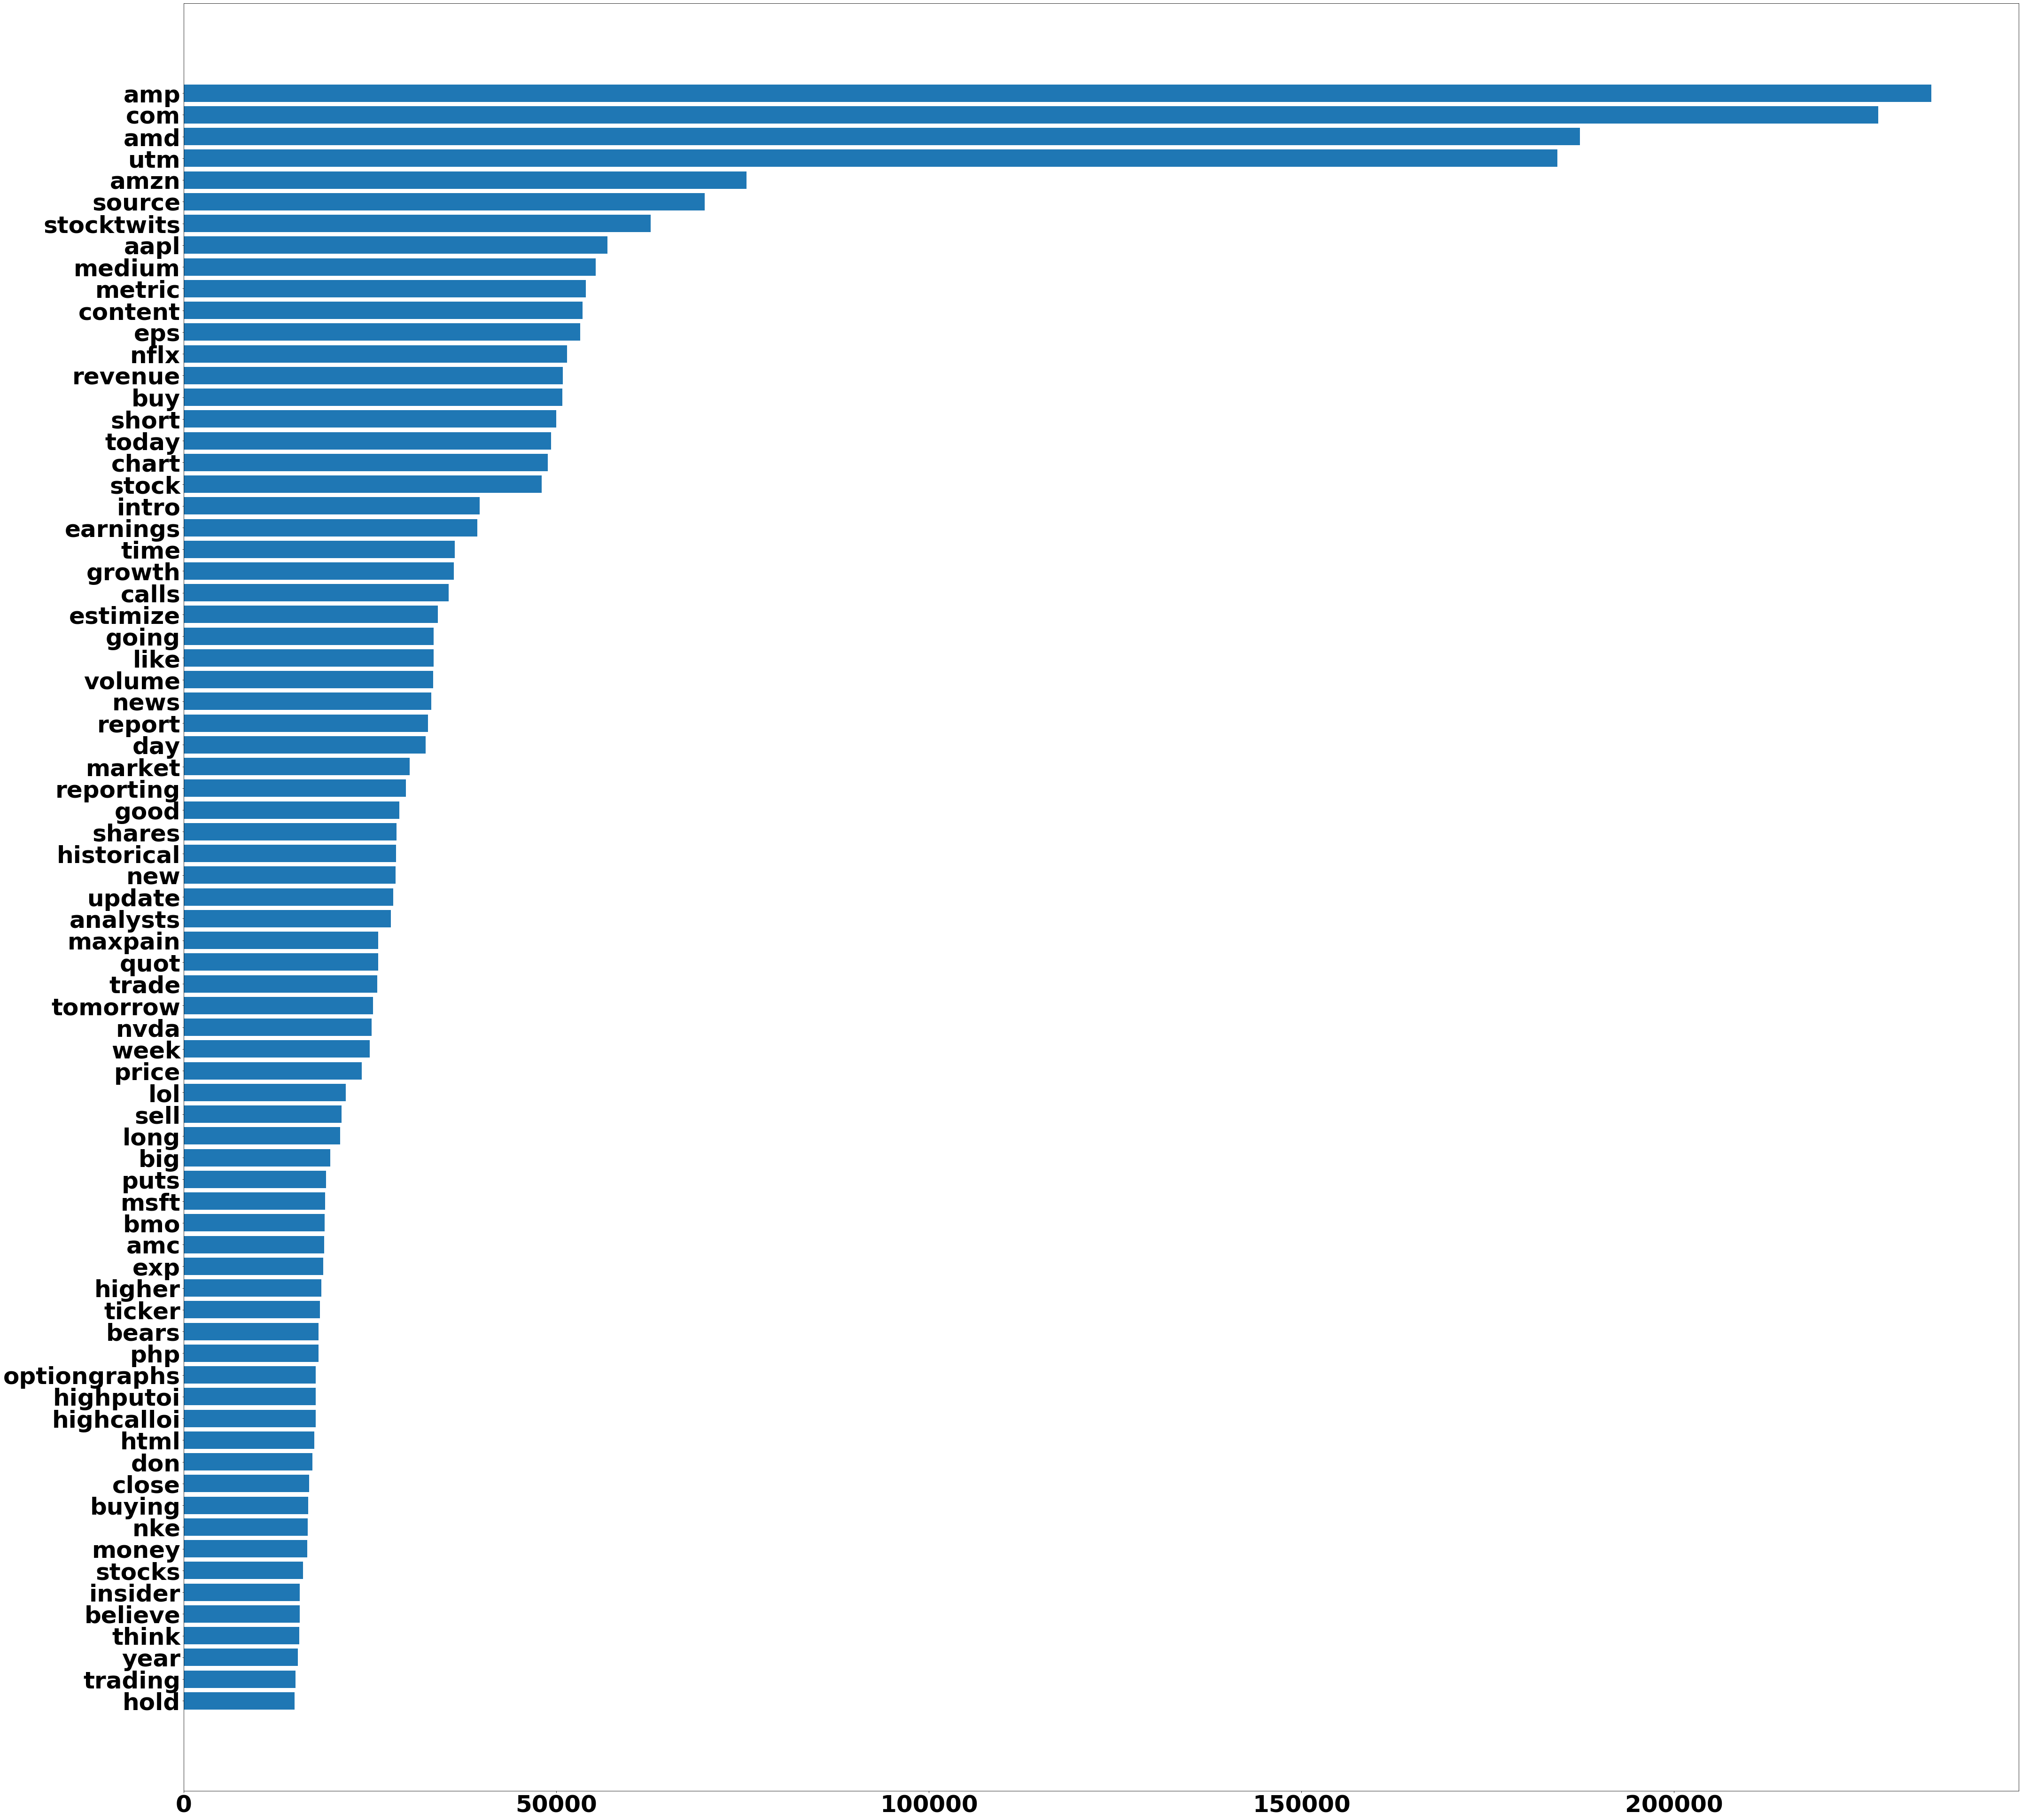

In [141]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 50}

plt.rc('font', **font)
fig = plt.figure(figsize=(70,70))
plt.barh(values_test[:75], counts_test[:75])
plt.gca().invert_yaxis()
plt.show()

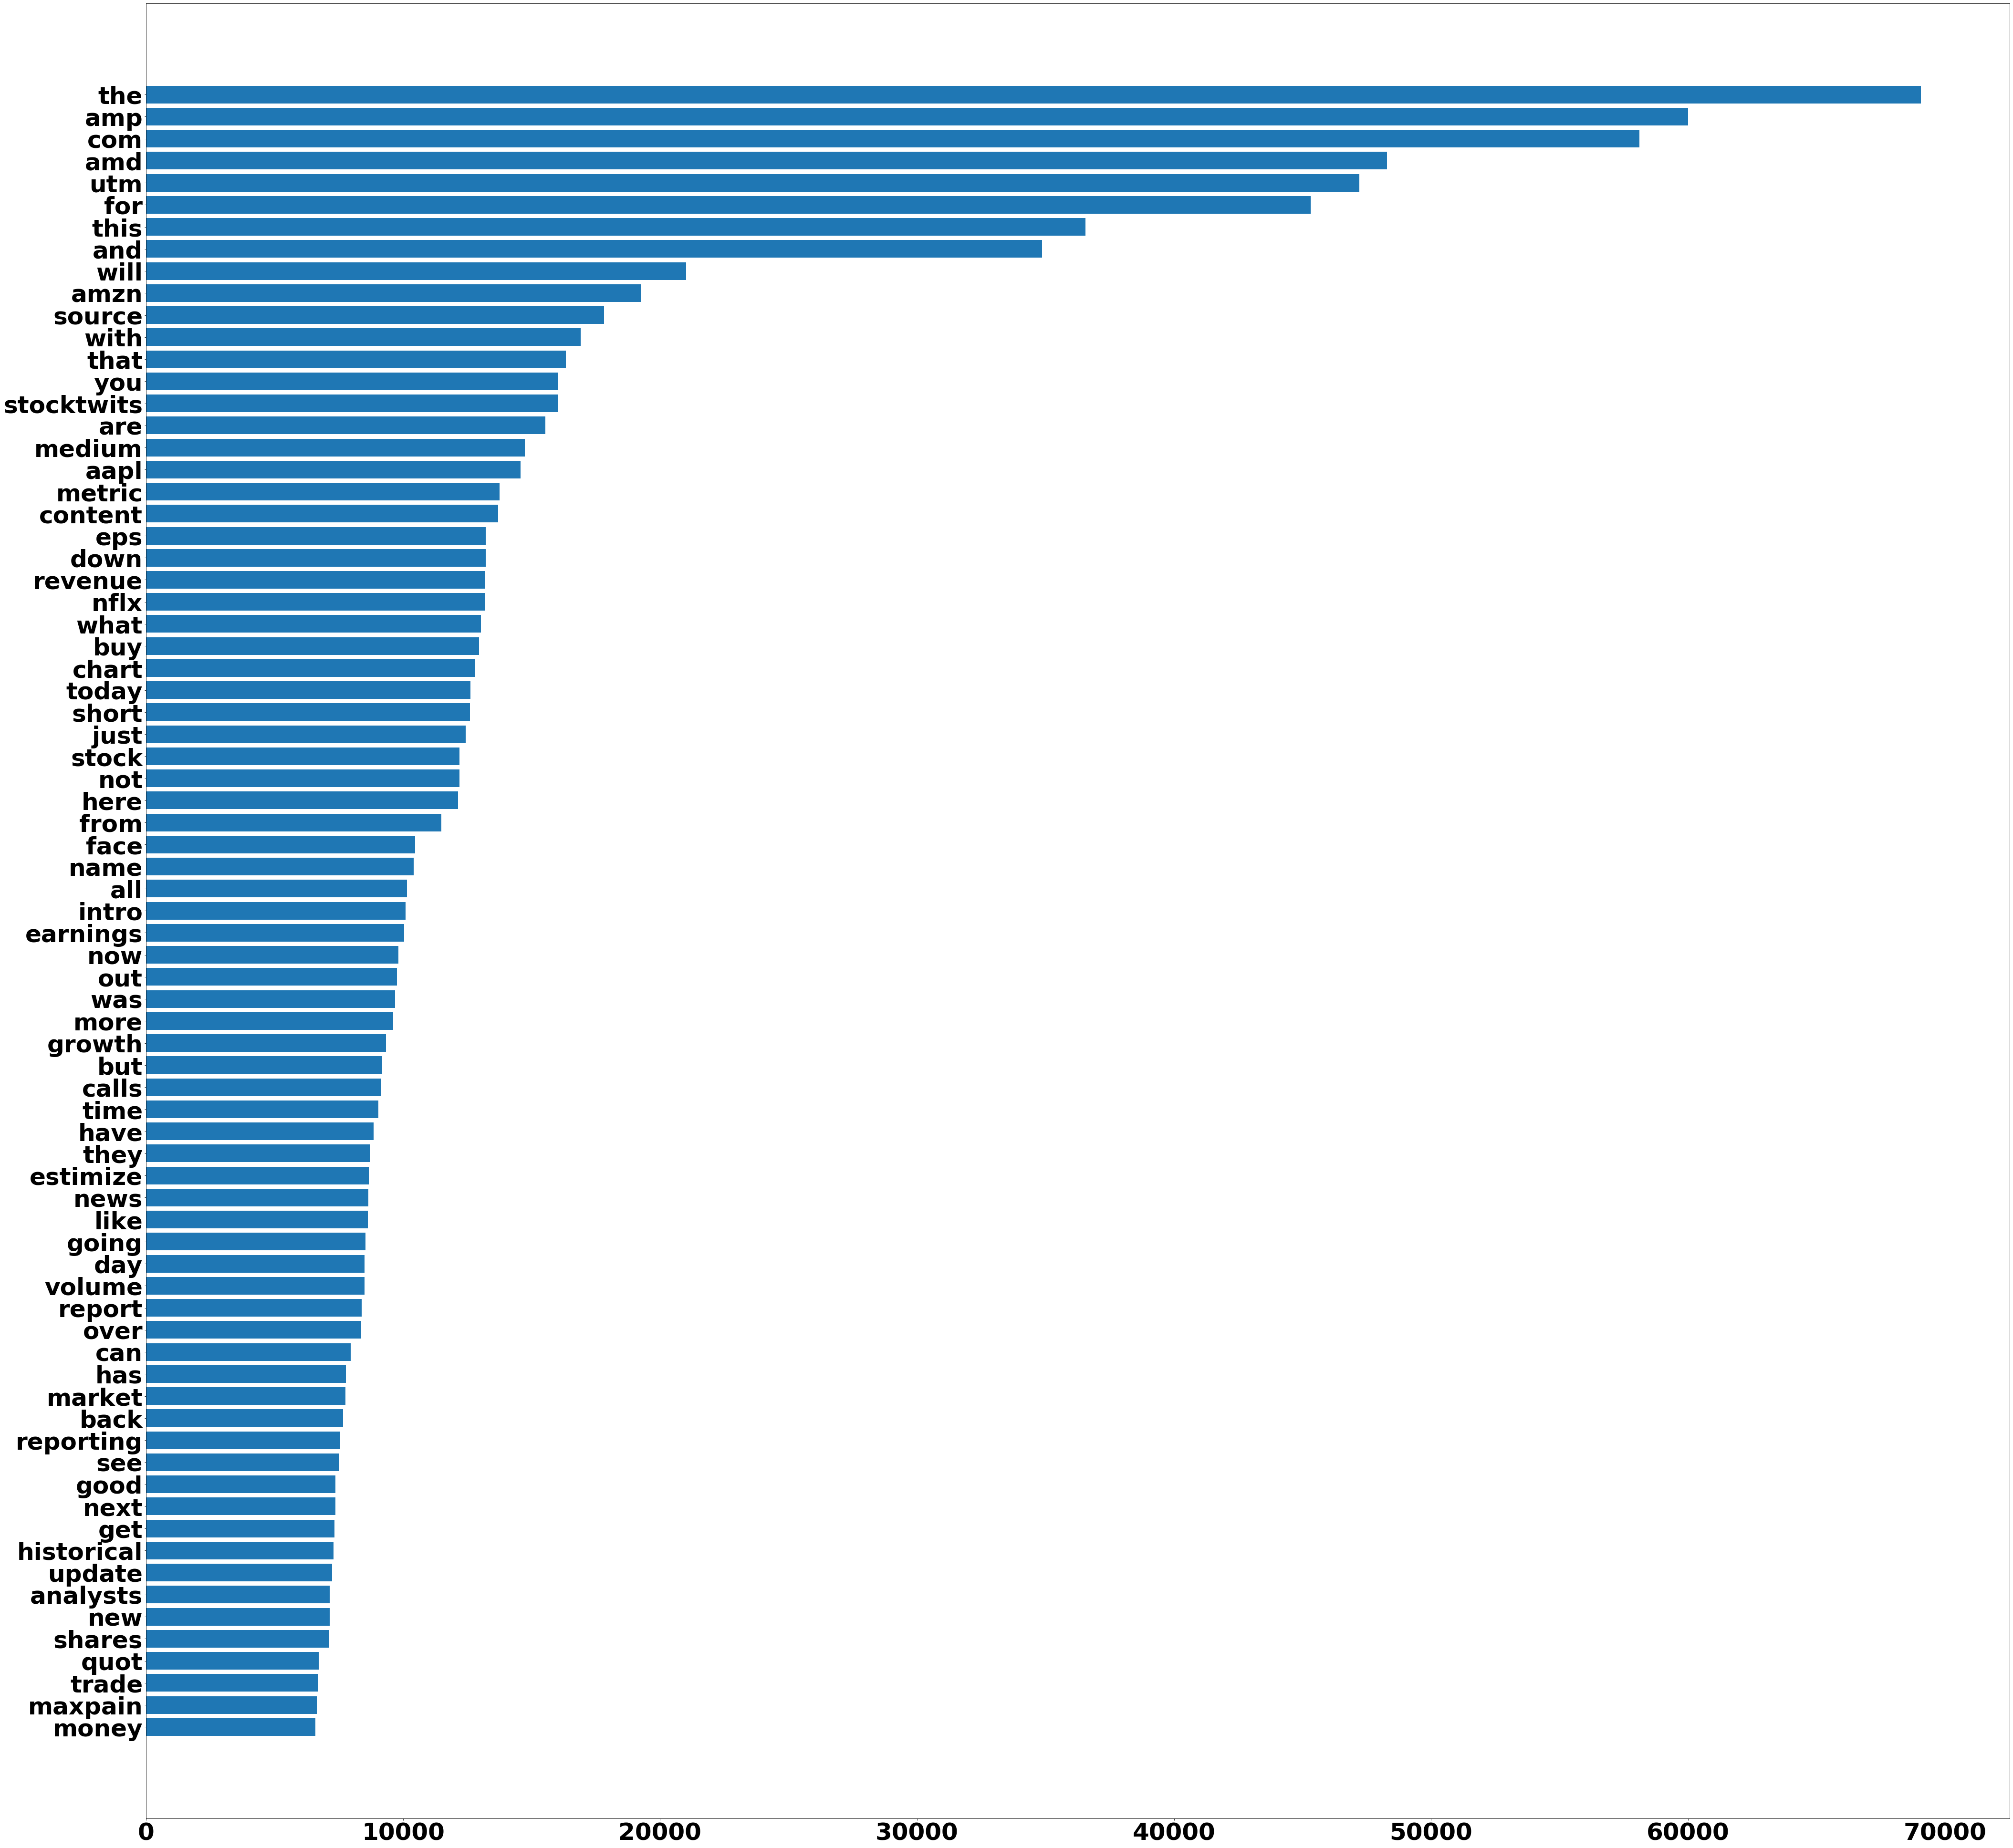

In [142]:
plt.rc('font', **font)
fig = plt.figure(figsize=(70,70))
plt.barh(all_values_test[:75], all_counts_test[:75])
plt.gca().invert_yaxis()
plt.show()

## countvectorizer

In [143]:
## tfidf vectorizer needs sentence and not token. Hence we need to combine all the tokens back to form a string
data_test['clean_tweet_stemmed'] = [' '.join(text) for text in data_test['clean_tweet_stemmed']]
data_test['clean_tweet_lemmatized'] = [' '.join(text) for text in data_test['clean_tweet_lemmatized']]
data_test['clean_tweet_lemmatized'][0]

'celg exit'

In [144]:
test_tweet=data_test['clean_tweet_lemmatized']

In [145]:
len(test_tweet)

265022

In [146]:
data_test_cv=countvector_train.transform(test_tweet)

In [147]:
sentiment=Classifier.predict(data_test_cv)

In [148]:
final_senti= pd.DataFrame(columns=['ticker', 'WeekNumber','sentiment_score','date'])

In [149]:
final_senti['sentiment_score']=sentiment

In [150]:
final_senti['ticker']=data_test['ticker']

In [151]:
final_senti['WeekNumber']=data_test['WeekNumber']

In [152]:
final_senti['date']=data_test['date']

In [153]:
len(final_senti['sentiment_score'])

265022

In [154]:
final_senti.head(5)

,ticker,WeekNumber,sentiment_score,date
0,CELG,43,2,2018-10-25
1,AMD,28,4,2018-07-13
2,AMD,39,2,2018-09-25
3,CBS,30,2,2018-07-27
4,MU,31,3,2018-07-31


In [155]:
data_test.keys()

dict_keys(['index', 'stocktwit_tweet', 'timestamp', 'ticker', 'tweets', 'word_count', 'Month', 'Day', 'weekday', 'WeekNumber', 'date', 'clean_tweet_stemmed', 'clean_tweet_lemmatized', 'tweet_stemmed', 'tweet_lemmatized'])

In [156]:
final_senti.isnull().sum()

ticker             0
WeekNumber         0
sentiment_score    0
date               0
dtype: int64

In [157]:
final_senti.dtypes

ticker                     object
WeekNumber                  int64
sentiment_score             int32
date               datetime64[ns]
dtype: object

In [158]:
final_senti['ticker']=final_senti['ticker'].astype('category')

In [159]:
final_senti['sentiment_score']=final_senti['sentiment_score'].astype('category')

In [160]:
final_senti.to_csv('final_sentiment.csv')

In [161]:
test_data=pd.DataFrame.from_dict(data_test)

In [162]:
test_data.shape

(265022, 15)

In [163]:
test_data.head(3)

,index,stocktwit_tweet,timestamp,ticker,tweets,word_count,Month,Day,weekday,WeekNumber,date,clean_tweet_stemmed,clean_tweet_lemmatized,tweet_stemmed,tweet_lemmatized
0,0,$CELG nothing to be exited about,2018-10-25 14:26:16,CELG,celg nothing exited about,4,October,25,Thursday,43,2018-10-25,celg exit,celg exit,"[celg, noth, exit, about]","[celg, nothing, exit, about]"
1,1,$AMD yall exhaust your buyer on first green ca...,2018-07-13 13:50:39,AMD,amd yall exhaust your buyer first green candle...,9,July,13,Friday,28,2018-07-13,amd y exhaust buyer green candl byeeeeee,amd -PRON- exhaust buyer green candle byeeeeee,"[amd, y, all, exhaust, your, buyer, first, gre...","[amd, -PRON-, all, exhaust, -PRON-, buyer, fir..."
2,2,$AMD day traders day.,2018-09-25 19:10:54,AMD,amd day traders day,4,September,25,Tuesday,39,2018-09-25,amd day trader day,amd day trader day,"[amd, day, trader, day]","[amd, day, trader, day]"


## Predicting the alpha by adding these predicted sentiment score

In [220]:
test_data=pd.read_csv('test_factors.csv')

In [221]:
test_data.shape

(11575, 10)

In [222]:
test_data.head(3)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,21/07/18,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,05/10/18,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,01/10/18,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811


In [223]:
test_data['date']=pd.to_datetime(test_data['date'].astype(str),format="%d/%m/%y")
test_data.head(3)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,2018-10-05,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,2018-10-01,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811


In [224]:
test_data['Month']=test_data['date'].dt.month_name(locale='English')
test_data['Day']=test_data['date'].dt.day
test_data['weekday']=test_data['date'].dt.weekday_name

In [225]:
weeknumber=[]
for i in range(test_data.shape[0]):
    weeknumber.append(test_data['date'][i].isocalendar()[1])
test_data['WeekNumber']=weeknumber
test_data.head(3)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Month,Day,weekday,WeekNumber
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,July,21,Saturday,29
1,270008,2018-10-05,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,October,5,Friday,40
2,270009,2018-10-01,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,October,1,Monday,40


In [226]:
test_data['ticker']=[re.sub("\$"," ",i) for i in test_data['ticker']]

In [227]:
test_data['ticker']=test_data['ticker'].astype('category')

### merging with sentiment score

In [232]:
test=pd.read_csv("final_sentiment.csv")

In [233]:
test.head(3)

,ticker,WeekNumber,sentiment_score,date
0,CELG,43,2,25-10-2018
1,AMD,28,4,13-07-2018
2,AMD,39,2,25-09-2018


In [234]:
test.drop(['date'], axis=1, inplace=True)

In [235]:
test_data.head(2)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Month,Day,weekday,WeekNumber
0,270007,2018-07-21,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,July,21,Saturday,29
1,270008,2018-10-05,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,October,5,Friday,40


In [236]:
test_data.dtypes

Id                     int64
date          datetime64[ns]
ticker              category
SF1                  float64
SF2                  float64
SF3                  float64
SF4                  float64
SF5                  float64
SF6                  float64
SF7                  float64
Month                 object
Day                    int64
weekday               object
WeekNumber             int64
dtype: object

In [237]:
test_data['Month']=test_data['Month'].astype('category')

In [238]:
test_data['weekday']=test_data['weekday'].astype('category')

In [239]:
test_data.drop(['Id','date'], axis=1, inplace=True)

In [240]:
test_data.drop(['Day'], axis=1, inplace=True)

In [241]:
test['ticker']=test['ticker'].astype('category')

In [242]:
test.dtypes

ticker             category
WeekNumber            int64
sentiment_score       int64
dtype: object

In [243]:
sentiment= pd.DataFrame(test.groupby(['ticker','WeekNumber'])['sentiment_score'].mean())

In [244]:
sentiment.reset_index()

,ticker,WeekNumber,sentiment_score
0,DIS,26,NaN
1,DIS,27,NaN
2,DIS,28,2.0
3,DIS,29,NaN
4,DIS,30,NaN
...,...,...,...
27469,K,40,NaN
27470,K,41,NaN
27471,K,42,NaN
27472,K,43,NaN


In [245]:
final=pd.merge(test_data,sentiment, on=['ticker','WeekNumber'],how='left')

In [246]:
final.head(2)

,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Month,weekday,WeekNumber,sentiment_score
0,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,July,Saturday,29,1.920000
1,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,October,Friday,40,2.142857


In [247]:
final.isnull().sum()

ticker             0
SF1                0
SF2                0
SF3                0
SF4                0
SF5                0
SF6                0
SF7                0
Month              0
weekday            0
WeekNumber         0
sentiment_score    0
dtype: int64

### Standardizing and label encoding

In [248]:
final.dtypes

ticker               object
SF1                 float64
SF2                 float64
SF3                 float64
SF4                 float64
SF5                 float64
SF6                 float64
SF7                 float64
Month              category
weekday            category
WeekNumber            int64
sentiment_score     float64
dtype: object

In [249]:
final['ticker']=final['ticker'].astype('category')

In [250]:
final['WeekNumber']=final['WeekNumber'].astype('category')

In [251]:
num_Attributes=final.select_dtypes(['int64','float64']).columns
cat_Attributes = final.select_dtypes(include=['category']).columns

In [252]:
scaler = StandardScaler()
scaler.fit(final[num_Attributes])
final[num_Attributes]=scaler.transform(final[num_Attributes])

In [253]:
final['ticker'] = label_encoder.fit_transform(final['ticker']) 
final['Month'] = label_encoder.fit_transform(final['Month']) 
final['weekday'] = label_encoder.fit_transform(final['weekday'])

In [254]:
final.keys()

Index(['ticker', 'SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7', 'Month',
       'weekday', 'WeekNumber', 'sentiment_score'],
      dtype='object')

In [255]:
final.dtypes

ticker                int32
SF1                 float64
SF2                 float64
SF3                 float64
SF4                 float64
SF5                 float64
SF6                 float64
SF7                 float64
Month                 int32
weekday               int32
WeekNumber         category
sentiment_score     float64
dtype: object

In [256]:
final['ticker']=final['ticker'].astype('category')

In [257]:
final['Month']=final['Month'].astype('category')

In [258]:
final['weekday']=final['weekday'].astype('category')

### Submission of predicted alpha

In [259]:
sub_data= pd.read_csv('test_factors.csv',parse_dates=[0])

In [260]:
final_sub= pd.DataFrame(columns=['Id', 'alpha'])

In [261]:
final_sub['Id'] =sub_data['Id']

In [262]:
Randomforest = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

In [263]:
Randomforest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [264]:
alpha=Randomforest.predict(final)

In [265]:
final_sub['alpha']=alpha

In [266]:
final_sub.head(5)

,Id,alpha
0,270007,4
1,270008,4
2,270009,2
3,270010,3
4,270011,3


In [267]:
final_sub.to_csv("Submission.csv")